<a href="https://colab.research.google.com/github/simplgithub/ECE-2021-FIN-E-Ing4-Finance-Gr02-IA1/blob/main/Projet_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dans ce carnet nous allons mettre en place un modèle à réseau de neurones récurrent de type LSTM pour réaliser des prédictions sur notre série temporelle.

In [1]:
import urllib.request
import pandas as pd
from io import StringIO

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

# Création de la série temporelle

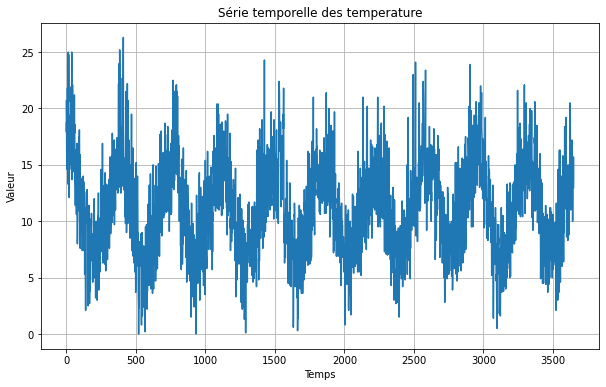

In [2]:
# Fonction permettant d'importer les données
def get_melbourne_data() -> pd.DataFrame:
    raw_url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
    response = urllib.request.urlopen(raw_url)
    response = response.read().decode('utf-8')
    data = pd.read_csv(StringIO(response))
    data['Date'] = pd.to_datetime(data['Date'])
    return data

# Fonction permettant d'afficher une série temporelle
def affiche_serie(temps, serie, format="-", debut=0, fin=None, label=None):
    plt.plot(temps[debut:fin], serie[debut:fin], format, label=label)
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# importation et visualisation de le ST
df = get_melbourne_data()
df["serie"] = df['Temp']
serie = df["serie"]
df["temps"] = range(0, df.shape[0])
temps = df["temps"]

plt.figure(figsize=(10, 6))
affiche_serie(temps,serie)
plt.title("Série temporelle des temperature")
plt.show()

# Préparation des données X et Y

In [ ]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle
# au format X(X1,X2,...Xn) / Y(Y1,Y2,...,Yn)
# X sont les données d'entrées du réseau
# Y sont les labels

def prepare_dataset_XY(serie, taille_fenetre, batch_size, buffer_melange):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(taille_fenetre+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + 1))
  dataset = dataset.shuffle(buffer_melange).map(lambda x: (x[:-1], x[-1:]))
  dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)
  return dataset

In [ ]:
df[df["Date"] == "1987-01-12"]
# Le temps de séparation qui correspond à au "1987-01-12" est 2201

,Date,Temp,serie,temps
2201,1987-01-12,12.4,12.4,2201


***Le temps de séparation qui correspond à au "1987-01-12" est t=2201. Nous allons ainsi définir les enchantillons d'apprentissage et de test***

**1. Séparation des données en données pour l'entrainement et la validation**

In [ ]:
temps_separation = 2201

# Extraction des temps et des données d'entrainement
temps_entrainement = temps[:temps_separation]
x_entrainement = serie[:temps_separation]

# Exctraction des temps et des données de valiadation
temps_validation = temps[temps_separation:]
x_validation = serie[temps_separation:]

**2. Préparation des données X et des labels Y**

On commence par créer notre dataset à partir de la série (remarque : les valeurs ci-dessous sont en réalité mélangées) :

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/split_XY_2.png?raw=true" width="1200"> 

In [ ]:
# Définition des caractéristiques du dataset que l'on souhaite créer
taille_fenetre = 20
batch_size = 32
buffer_melange = 1000

# Création du dataset X,Y
dataset = prepare_dataset_XY(x_entrainement,taille_fenetre,batch_size,buffer_melange)

# Création du dataset X,Y de validation
dataset_Val = prepare_dataset_XY(x_validation,taille_fenetre,batch_size,buffer_melange)

**3. Normalisation des données**

In [ ]:
# Calcul de la moyenne et de l'écart type de la série
mean = tf.math.reduce_mean(serie)
std = tf.math.reduce_std(serie)

# Normalise les données
Serie_Normalisee = (serie-mean)/std
min = tf.math.reduce_min(serie)
max = tf.math.reduce_max(serie)

In [ ]:
# Création des données pour l'entrainement et le test
x_entrainement_norm = Serie_Normalisee[:temps_separation]
x_validation_norm = Serie_Normalisee[temps_separation:]

# Création du dataset X,Y
dataset_norm = prepare_dataset_XY(x_entrainement_norm,taille_fenetre,batch_size,buffer_melange)

# Création du dataset X,Y de validation
dataset_Val_norm = prepare_dataset_XY(x_validation_norm,taille_fenetre,batch_size,buffer_melange)

# Création du modèle LSTM

# 1. Création du réseau et adaptation des formats d'entrée et de sortie

Le réseau que nous allons mettre en place est un réseau de neurones récurrent, composé de :
  - Une couche récurrente LSTM à 40 neurones, de type séquence vers vecteur (sequence to vector) (Encodeur)
  - Une couche dense avec 40 neurones et fonction d'activation tanh (Décodeur)
  - Une couche dense avec 1 neurone (Générateur)

Pour adapter les données en entrée et en sortie du réseau au format attendu, nous allons utiliser une [couche de type lambda](https://keras.io/api/layers/core_layers/lambda/) avec Keras. Ce type de couche nous permet d'intégrer une fonction spécifique en tant que couche dans notre réseau de neurone.

- En entrée de la première couche récurrente, le format attendu est de type : [batch_size, #instants, #dims].   
Le **format d'entrée attendu est donc [None,None,1]** car notre série temporelle est de type univariée, qu'on souhaite pouvoir traiter une séquence infinie, et que le batch size est géré automatiquement par tensorflow.  
Il faut donc en entrée transformer le format [taille_fenetre, 1] vers le format [None, None, 1].  

- En sortie de la deuxième couche récurrente, le format est de type [batch_size, #instants, #neurones]. Il sera de type [None, None, 40].  
- La couche dense possède un seul neurone. En **sortie de la couche dense, le format est de type [None, None, 1]**.

Sous Keras, nous allons utiliser une couche récurrente de type LSTM avec la classe [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/). En sortie, la fonction d'activation par défaut est de type `tanh` qui sort une sortie comprise entre [-1,1].

Sous forme de shéma, notre réseau est donc le suivant :


<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/LSTM_1111.png?raw=true" width="1200"> 

Pour insérer une dimension de type `None` au format de l'entrée, on utilise la méthode [expand_dims](https://www.tensorflow.org/api_docs/python/tf/expand_dims) de tensorflow. 

In [ ]:
# Remise à zéro de tous les états générés par Keras
tf.keras.backend.clear_session()

In [ ]:
# Fonction de la couche lambda d'entrée
def Traitement_Entrees(x):
  return tf.expand_dims(x,axis=-1)

# Définition de l'entrée du modèle
entrees = tf.keras.layers.Input(shape=(taille_fenetre))

# Encodeur
e_adapt = tf.keras.layers.Lambda(Traitement_Entrees)(entrees)
s_encodeur = tf.keras.layers.LSTM(40)(e_adapt)

# Décodeur
s_decodeur = tf.keras.layers.Dense(40,activation="tanh")(s_encodeur)
s_decodeur = tf.keras.layers.Concatenate()([s_decodeur,s_encodeur])

# Générateur
sortie = tf.keras.layers.Dense(1)(s_decodeur)

# Construction du modèle
model = tf.keras.Model(entrees,sortie)

model.save_weights("model_initial.hdf5")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 lambda (Lambda)                (None, 20, 1)        0           ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 40)           6720        ['lambda[0][0]']                 
                                                                                                  
 dense (Dense)                  (None, 40)           1640        ['lstm[0][0]']                   
                                                                                              

In [ ]:
# Chargement des poids sauvegardés
model.load_weights("model_initial.hdf5")

# 2. Optimisation du taux d'apprentissage

In [ ]:
# Remise à zéro de tous les états générés par Keras
tf.keras.backend.clear_session()
model.load_weights("model_initial.hdf5")

In [ ]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur, metrics="mae")

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset_norm,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


     66/Unknown - 3s 10ms/step - loss: 0.4006 - mae: 0.7720
Epoch 1: loss improved from inf to 0.39813, saving model to poids.hdf5
68/68 [==============================] - 3s 15ms/step - loss: 0.3981 - mae: 0.7689 - lr: 1.0000e-08
Epoch 2/100
62/68 [==========================>...] - ETA: 0s - loss: 0.4012 - mae: 0.7728
Epoch 2: loss did not improve from 0.39813
68/68 [==============================] - 1s 10ms/step - loss: 0.3985 - mae: 0.7695 - lr: 1.2589e-08
Epoch 3/100
65/68 [===========================>..] - ETA: 0s - loss: 0.4013 - mae: 0.7733
Epoch 3: loss improved from 0.39813 to 0.39808, saving model to poids.hdf5
68/68 [==============================] - 1s 10ms/step - loss: 0.3981 - mae: 0.7689 - lr: 1.5849e-08
Epoch 4/100
65/68 [===========================>..] - ETA: 0s - loss: 0.3986 - mae: 0.7697
Epoch 4: loss did not improve from 0.39808
68/68 [==============================] - 1s 10ms/step - loss: 0.3983 - mae: 0.7690 - lr: 1.9953e-08
Epoch 5/100
64/68 [===================

Text(0.5, 1.0, "Evolution de l'erreur en fonction du taux d'apprentissage")

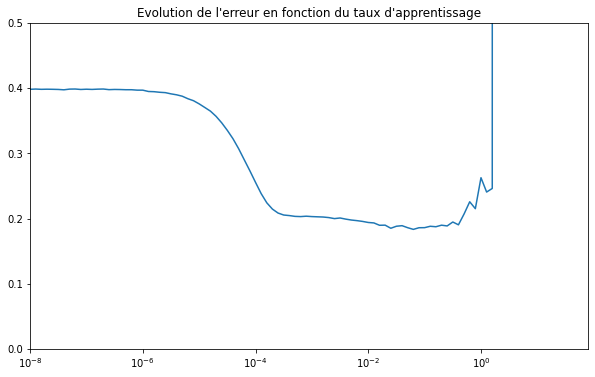

In [ ]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[0], taux[99], 0, 0.5])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

**Nous Constatons que notre modèle fait de l'overfiting. pour obtenir des meilleurs résultats, nous allons positionner l'optimiseur à 1e-1**

# 3. Entrainement du modèle

In [ ]:
# Remise à zéro des états du modèle
tf.keras.backend.clear_session()

In [ ]:
# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

In [ ]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.n_steps = 0
        self.t_step = 0
        self.n_batch = 0
        self.total_batch = 0
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.t_step = self.t_step  + timer()-self.starttime
        self.n_steps = self.n_steps + 1
        if (self.total_batch == 0):
          self.total_batch=self.n_batch - 1
    def on_train_batch_begin(self,batch,logs=None):
      self.n_batch= self.n_batch + 1
    def GetInfos(self):
      return([self.t_step/(self.n_steps*self.total_batch), self.t_step, self.total_batch])

cb = TimingCallback()

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(lr=1e-1,momentum=0.9) # on a positionné l'optimiseur à 1e-1

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_entrainement.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur,metrics="mae")

# Entraine le modèle
historique = model.fit(dataset_norm,validation_data=dataset_Val_norm, epochs=500,verbose=1, callbacks=[CheckPoint,cb])

# Affiche quelques informations sur les timings
infos = cb.GetInfos()
print("Step time : %.3f" %infos[0])
print("Total time : %.3f" %infos[1])

Epoch 1/500


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


     63/Unknown - 2s 11ms/step - loss: 0.1850 - mae: 0.4883
Epoch 1: loss improved from inf to 0.18622, saving model to poids_entrainement.hdf5
68/68 [==============================] - 4s 28ms/step - loss: 0.1862 - mae: 0.4894 - val_loss: 0.1727 - val_mae: 0.4735
Epoch 2/500
65/68 [===========================>..] - ETA: 0s - loss: 0.1854 - mae: 0.4885
Epoch 2: loss improved from 0.18622 to 0.18525, saving model to poids_entrainement.hdf5
68/68 [==============================] - 1s 16ms/step - loss: 0.1852 - mae: 0.4881 - val_loss: 0.1612 - val_mae: 0.4534
Epoch 3/500
67/68 [============================>.] - ETA: 0s - loss: 0.1887 - mae: 0.4923
Epoch 3: loss did not improve from 0.18525
68/68 [==============================] - 1s 16ms/step - loss: 0.1873 - mae: 0.4898 - val_loss: 0.1616 - val_mae: 0.4538
Epoch 4/500
65/68 [===========================>..] - ETA: 0s - loss: 0.1888 - mae: 0.4954
Epoch 4: loss did not improve from 0.18525
68/68 [==============================] - 1s 15ms/ste

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

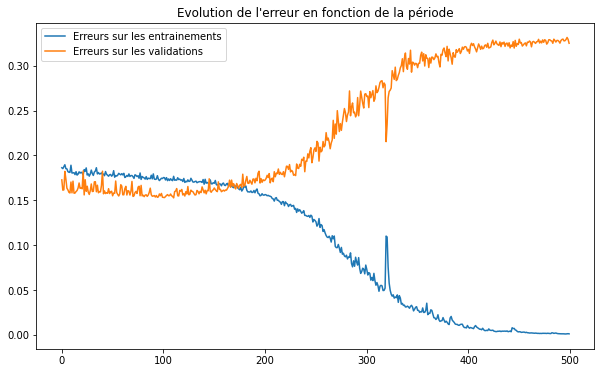

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

**IL est clair que notre modèle n'est pas bon puiqu'il surapprend à une allure exponentielle. Notre essayerons une autre modèle plus adapté en diminuant le taux d'apprentissage lorsque le nombre de période augmente.**

# 4. Adaptation du taux d'apprentissage

In [ ]:
# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

**On commence par une taux d'apprentissage de 0,1 et on fait en sorte que pour chaque période supplémentaire il soit diminuer de 1%.**

In [ ]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.n_steps = 0
        self.t_step = 0
        self.n_batch = 0
        self.total_batch = 0
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.t_step = self.t_step  + timer()-self.starttime
        self.n_steps = self.n_steps + 1
        if (self.total_batch == 0):
          self.total_batch=self.n_batch - 1
    def on_train_batch_begin(self,batch,logs=None):
      self.n_batch= self.n_batch + 1
    def GetInfos(self):
      return([self.t_step/(self.n_steps*self.total_batch), self.t_step, self.total_batch])

cb = TimingCallback()

# Définition des paramètres liés à l'évolution du taux d'apprentissage
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.1,
    decay_steps=10,
    decay_rate=0.01)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(learning_rate=lr_schedule,momentum=0.9)

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_entrainement.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur,metrics="mae")

# Entraine le modèle
historique = model.fit(dataset_norm,validation_data=dataset_Val_norm, epochs=500,verbose=1, callbacks=[CheckPoint,cb])

# Affiche quelques informations sur les timings
infos = cb.GetInfos()
print("Step time : %.3f" %infos[0])
print("Total time : %.3f" %infos[1])

Epoch 1/500
     67/Unknown - 3s 12ms/step - loss: 0.2345 - mae: 0.5589
Epoch 1: loss improved from inf to 0.23454, saving model to poids_entrainement.hdf5
68/68 [==============================] - 5s 35ms/step - loss: 0.2345 - mae: 0.5592 - val_loss: 0.1861 - val_mae: 0.4852
Epoch 2/500
65/68 [===========================>..] - ETA: 0s - loss: 0.2003 - mae: 0.5097
Epoch 2: loss improved from 0.23454 to 0.20047, saving model to poids_entrainement.hdf5
68/68 [==============================] - 1s 18ms/step - loss: 0.2005 - mae: 0.5104 - val_loss: 0.1732 - val_mae: 0.4674
Epoch 3/500
63/68 [==========================>...] - ETA: 0s - loss: 0.1932 - mae: 0.4993
Epoch 3: loss improved from 0.20047 to 0.19415, saving model to poids_entrainement.hdf5
68/68 [==============================] - 1s 19ms/step - loss: 0.1942 - mae: 0.5008 - val_loss: 0.1747 - val_mae: 0.4734
Epoch 4/500
66/68 [============================>.] - ETA: 0s - loss: 0.1868 - mae: 0.4904
Epoch 4: loss improved from 0.19415 to

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

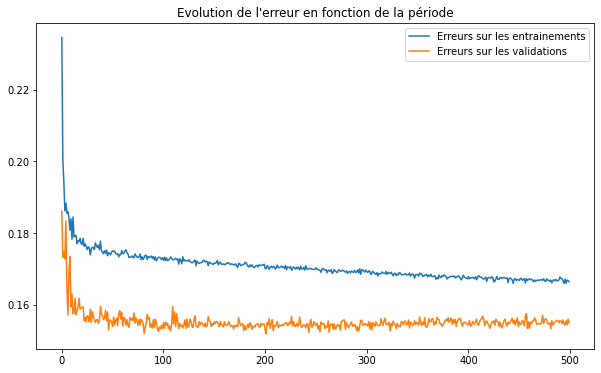

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

**Nous avons pu resoudre le problème de l'overfiting en diminuant les erreurs sur les données de validations**

# 5. Prédictions

Puisque le format d'entrée permet de prendre des séquences infinies, nous pouvons entrer des séquences de n'importe quelle taille :

In [ ]:
taille_fenetre = 20
Serie_Normalisee = np.array(Serie_Normalisee)

# Création d'une liste vide pour recevoir les prédictions
predictions = []

# Calcul des prédiction pour chaque groupe de 20 valeurs consécutives de la série
# dans l'intervalle de validation
for t in temps[temps_separation:-taille_fenetre]:
    X = np.reshape(Serie_Normalisee[t:t+taille_fenetre],(1,taille_fenetre))
    predictions.append(model.predict(X))

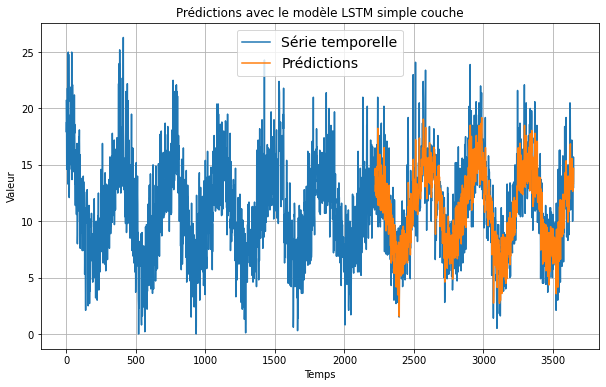

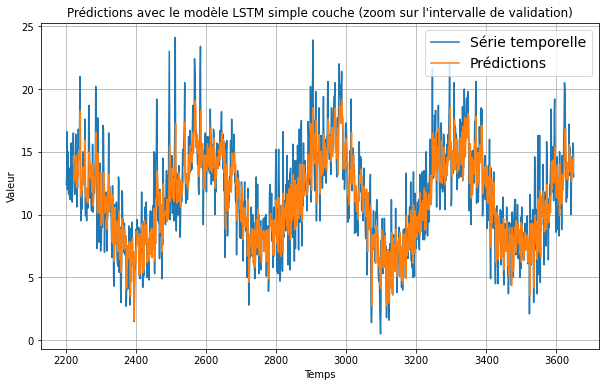

In [ ]:
# Affiche la série et les prédictions
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie,label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0],label="Prédictions")
plt.title('Prédictions avec le modèle LSTM simple couche')
plt.show()

# Zoom sur l'intervalle de validation
plt.figure(figsize=(10, 6))
affiche_serie(temps[temps_separation:],serie[temps_separation:],label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0],label="Prédictions")
plt.title("Prédictions avec le modèle LSTM simple couche (zoom sur l'intervalle de validation)")
plt.show()

In [ ]:
# Calcule de l'erreur quadratique moyenne et de l'erreur absolue moyenne 

mae = tf.keras.metrics.mean_absolute_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0]).numpy()
mse = tf.keras.metrics.mean_squared_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0]).numpy()

print(mae)
print(mse)

1.8076931561974006
5.356233981002425


# 6. Ajout de la régularisation

In [ ]:
# Remise à zéro des états du modèle
tf.keras.backend.clear_session()
model.load_weights("model_initial.hdf5")

In [ ]:
# Fonction de la couche lambda d'entrée
def Traitement_Entrees(x):
  return tf.expand_dims(x,axis=-1)

# Définition de l'entrée du modèle
entrees = tf.keras.layers.Input(shape=(taille_fenetre))

# Encodeur
e_adapt = tf.keras.layers.Lambda(Traitement_Entrees)(entrees)
s_encodeur = tf.keras.layers.LSTM(40,kernel_regularizer=tf.keras.regularizers.l2(1e-5))(e_adapt)

# Décodeur
s_decodeur = tf.keras.layers.Dense(40,activation="tanh")(s_encodeur)
s_decodeur = tf.keras.layers.Concatenate()([s_decodeur,s_encodeur])

# Générateur
sortie = tf.keras.layers.Dense(1)(s_decodeur)

# Construction du modèle
model = tf.keras.Model(entrees,sortie)

model.save_weights("model_initial.hdf5")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 lambda (Lambda)                (None, 20, 1)        0           ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 40)           6720        ['lambda[0][0]']                 
                                                                                                  
 dense (Dense)                  (None, 40)           1640        ['lstm[0][0]']                   
                                                                                              

In [ ]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur, metrics="mae")

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset_norm,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


     66/Unknown - 3s 11ms/step - loss: 0.4368 - mae: 0.8172
Epoch 1: loss improved from inf to 0.43533, saving model to poids.hdf5
68/68 [==============================] - 3s 15ms/step - loss: 0.4353 - mae: 0.8153 - lr: 1.0000e-08
Epoch 2/100
64/68 [===========================>..] - ETA: 0s - loss: 0.4379 - mae: 0.8189
Epoch 2: loss improved from 0.43533 to 0.43417, saving model to poids.hdf5
68/68 [==============================] - 1s 11ms/step - loss: 0.4342 - mae: 0.8142 - lr: 1.2589e-08
Epoch 3/100
68/68 [==============================] - ETA: 0s - loss: 0.4358 - mae: 0.8160
Epoch 3: loss did not improve from 0.43417
68/68 [==============================] - 1s 11ms/step - loss: 0.4358 - mae: 0.8160 - lr: 1.5849e-08
Epoch 4/100
63/68 [==========================>...] - ETA: 0s - loss: 0.4425 - mae: 0.8246
Epoch 4: loss did not improve from 0.43417
68/68 [==============================] - 1s 11ms/step - loss: 0.4357 - mae: 0.8159 - lr: 1.9953e-08
Epoch 5/100
63/68 [===================

Text(0.5, 1.0, "Evolution de l'erreur en fonction du taux d'apprentissage")

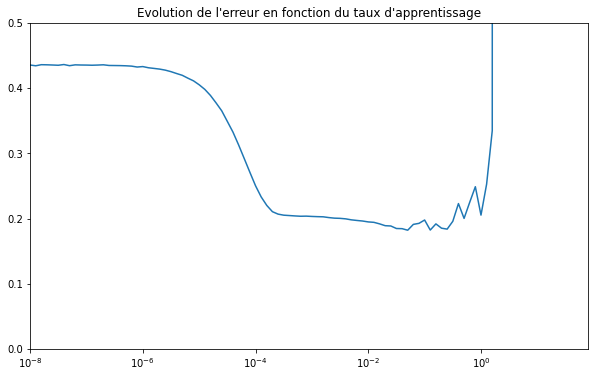

In [ ]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[0], taux[99], 0, 0.5])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

In [ ]:
# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

In [ ]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.n_steps = 0
        self.t_step = 0
        self.n_batch = 0
        self.total_batch = 0
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.t_step = self.t_step  + timer()-self.starttime
        self.n_steps = self.n_steps + 1
        if (self.total_batch == 0):
          self.total_batch=self.n_batch - 1
    def on_train_batch_begin(self,batch,logs=None):
      self.n_batch= self.n_batch + 1
    def GetInfos(self):
      return([self.t_step/(self.n_steps*self.total_batch), self.t_step, self.total_batch])

cb = TimingCallback()

# Définition des paramètres liés à l'évolution du taux d'apprentissage
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=10,
    decay_rate=0.01)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(learning_rate=lr_schedule,momentum=0.9)

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_entrainement.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur,metrics="mae")

# Entraine le modèle
historique = model.fit(dataset_norm,validation_data=dataset_Val_norm, epochs=500,verbose=1, callbacks=[CheckPoint,cb])

# Affiche quelques informations sur les timings
infos = cb.GetInfos()
print("Step time : %.3f" %infos[0])
print("Total time : %.3f" %infos[1])

Epoch 1/500
     63/Unknown - 3s 11ms/step - loss: 0.1812 - mae: 0.4809
Epoch 1: loss improved from inf to 0.17945, saving model to poids_entrainement.hdf5
68/68 [==============================] - 4s 29ms/step - loss: 0.1794 - mae: 0.4802 - val_loss: 0.1582 - val_mae: 0.4482
Epoch 2/500
68/68 [==============================] - ETA: 0s - loss: 0.1811 - mae: 0.4827
Epoch 2: loss did not improve from 0.17945
68/68 [==============================] - 1s 16ms/step - loss: 0.1811 - mae: 0.4827 - val_loss: 0.1607 - val_mae: 0.4514
Epoch 3/500
67/68 [============================>.] - ETA: 0s - loss: 0.1774 - mae: 0.4792
Epoch 3: loss improved from 0.17945 to 0.17746, saving model to poids_entrainement.hdf5
68/68 [==============================] - 1s 16ms/step - loss: 0.1775 - mae: 0.4793 - val_loss: 0.1600 - val_mae: 0.4484
Epoch 4/500
64/68 [===========================>..] - ETA: 0s - loss: 0.1773 - mae: 0.4774
Epoch 4: loss did not improve from 0.17746
68/68 [==============================] -

In [ ]:
taille_fenetre = 20

# Création d'une liste vide pour recevoir les prédictions
predictions = []
Serie_Normalisee = np.array(Serie_Normalisee)
# Calcul des prédiction pour chaque groupe de 20 valeurs consécutives de la série
# dans l'intervalle de validation
for t in temps[temps_separation:-taille_fenetre]:
    X = np.reshape(Serie_Normalisee[t:t+taille_fenetre],(1,taille_fenetre))
    predictions.append(model.predict(X))

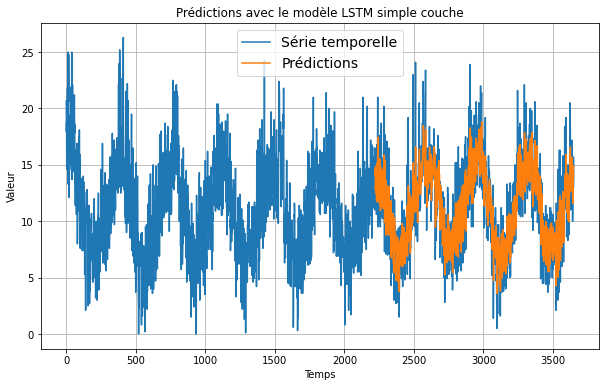

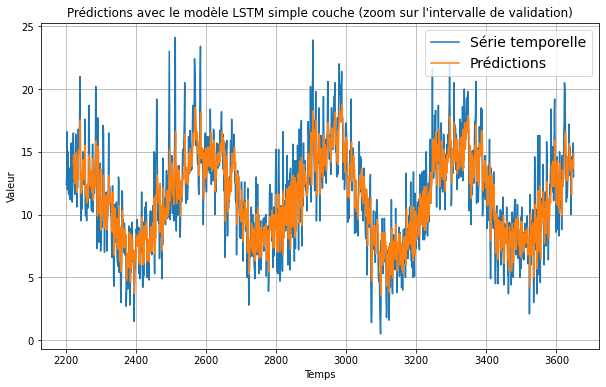

In [ ]:
# Affiche la série et les prédictions
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie,label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0],label="Prédictions")
plt.title('Prédictions avec le modèle LSTM simple couche')
plt.show()

# Zoom sur l'intervalle de validation
plt.figure(figsize=(10, 6))
affiche_serie(temps[temps_separation:],serie[temps_separation:],label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0],label="Prédictions")
plt.title("Prédictions avec le modèle LSTM simple couche (zoom sur l'intervalle de validation)")
plt.show()

In [ ]:
# Calcule de l'erreur quadratique moyenne et de l'erreur absolue moyenne 

mae = tf.keras.metrics.mean_absolute_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0]).numpy()
mse = tf.keras.metrics.mean_squared_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0]).numpy()

print(mae)
print(mse)

1.8014878668460166
5.322318351820038


# 7. Création du modèle LSTM Bi-directionnel

**1. Construction du modèle**

In [ ]:
# Remise à zéro des états du modèle
tf.keras.backend.clear_session()
model.load_weights("model_initial.hdf5")

In [ ]:
# Fonction de la couche lambda d'entrée
def Traitement_Entrees(x):
  return tf.expand_dims(x,axis=-1)

# Définition de l'entrée du modèle
entrees = tf.keras.layers.Input(shape=(taille_fenetre))

# Encodeur
e_adapt = tf.keras.layers.Lambda(Traitement_Entrees)(entrees)
s_encodeur = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40))(e_adapt)

# Décodeur
s_decodeur = tf.keras.layers.Dense(80,activation="tanh")(s_encodeur)
s_decodeur = tf.keras.layers.Concatenate()([s_decodeur,s_encodeur])

# Générateur
sortie = tf.keras.layers.Dense(1)(s_decodeur)

# Construction du modèle
model = tf.keras.Model(entrees,sortie)


model.save_weights("model_initial.hdf5")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 lambda (Lambda)                (None, 20, 1)        0           ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 80)           13440       ['lambda[0][0]']                 
                                                                                                  
 dense (Dense)                  (None, 80)           6480        ['bidirectional[0][0]']          
                                                                                              

**2. Optimisation du taux d'apprentissage**

In [ ]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(lr=1e-3,momentum=0.9)

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur, metrics="mae")

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset_norm,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


     64/Unknown - 4s 14ms/step - loss: 0.3475 - mae: 0.7042
Epoch 1: loss improved from inf to 0.34797, saving model to poids.hdf5
68/68 [==============================] - 4s 15ms/step - loss: 0.3480 - mae: 0.7049 - lr: 1.0000e-08
Epoch 2/100
67/68 [============================>.] - ETA: 0s - loss: 0.3490 - mae: 0.7062
Epoch 2: loss did not improve from 0.34797
68/68 [==============================] - 1s 14ms/step - loss: 0.3490 - mae: 0.7064 - lr: 1.2589e-08
Epoch 3/100
68/68 [==============================] - ETA: 0s - loss: 0.3491 - mae: 0.7062
Epoch 3: loss did not improve from 0.34797
68/68 [==============================] - 1s 14ms/step - loss: 0.3491 - mae: 0.7062 - lr: 1.5849e-08
Epoch 4/100
64/68 [===========================>..] - ETA: 0s - loss: 0.3514 - mae: 0.7094
Epoch 4: loss improved from 0.34797 to 0.34779, saving model to poids.hdf5
68/68 [==============================] - 1s 12ms/step - loss: 0.3478 - mae: 0.7048 - lr: 1.9953e-08
Epoch 5/100
65/68 [===================

Text(0.5, 1.0, "Evolution de l'erreur en fonction du taux d'apprentissage")

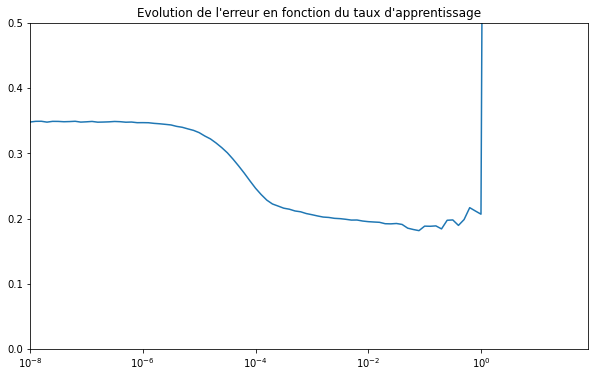

In [ ]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([taux[0], taux[99], 0, 0.5])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

**3. Entrainement du modèle**

In [ ]:
# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

In [ ]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.n_steps = 0
        self.t_step = 0
        self.n_batch = 0
        self.total_batch = 0
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.t_step = self.t_step  + timer()-self.starttime
        self.n_steps = self.n_steps + 1
        if (self.total_batch == 0):
          self.total_batch=self.n_batch - 1
    def on_train_batch_begin(self,batch,logs=None):
      self.n_batch= self.n_batch + 1
    def GetInfos(self):
      return([self.t_step/(self.n_steps*self.total_batch), self.t_step, self.total_batch])

cb = TimingCallback()

# Définition des paramètres liés à l'évolution du taux d'apprentissage
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.015,
    decay_steps=10,
    decay_rate=0.01)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(learning_rate=lr_schedule,momentum=0.9)

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_entrainement.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur,metrics="mae")

# Entraine le modèle
historique = model.fit(dataset_norm,validation_data=dataset_Val_norm, epochs=500,verbose=1, callbacks=[CheckPoint,cb])

# Affiche quelques informations sur les timings
infos = cb.GetInfos()
print("Step time : %.3f" %infos[0])
print("Total time : %.3f" %infos[1])

Epoch 1/500
     66/Unknown - 4s 13ms/step - loss: 0.1780 - mae: 0.4778
Epoch 1: loss improved from inf to 0.18005, saving model to poids_entrainement.hdf5
68/68 [==============================] - 6s 36ms/step - loss: 0.1800 - mae: 0.4800 - val_loss: 0.1602 - val_mae: 0.4475
Epoch 2/500
65/68 [===========================>..] - ETA: 0s - loss: 0.1759 - mae: 0.4757
Epoch 2: loss improved from 0.18005 to 0.17737, saving model to poids_entrainement.hdf5
68/68 [==============================] - 1s 19ms/step - loss: 0.1774 - mae: 0.4775 - val_loss: 0.1603 - val_mae: 0.4476
Epoch 3/500
68/68 [==============================] - ETA: 0s - loss: 0.1767 - mae: 0.4771
Epoch 3: loss improved from 0.17737 to 0.17672, saving model to poids_entrainement.hdf5
68/68 [==============================] - 1s 20ms/step - loss: 0.1767 - mae: 0.4771 - val_loss: 0.1603 - val_mae: 0.4491
Epoch 4/500
66/68 [============================>.] - ETA: 0s - loss: 0.1768 - mae: 0.4783
Epoch 4: loss did not improve from 0.1

In [ ]:
taille_fenetre = 20

# Création d'une liste vide pour recevoir les prédictions
predictions = []
Serie_Normalisee = np.array(Serie_Normalisee)

# Calcul des prédiction pour chaque groupe de 20 valeurs consécutives de la série
# dans l'intervalle de validation
for t in temps[temps_separation:-taille_fenetre]:
    X = np.reshape(Serie_Normalisee[t:t+taille_fenetre],(1,taille_fenetre))
    predictions.append(model.predict(X))

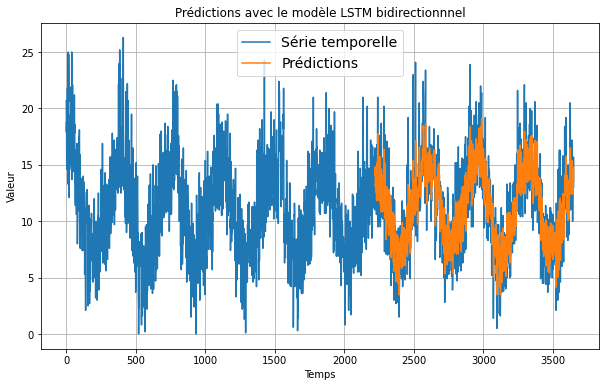

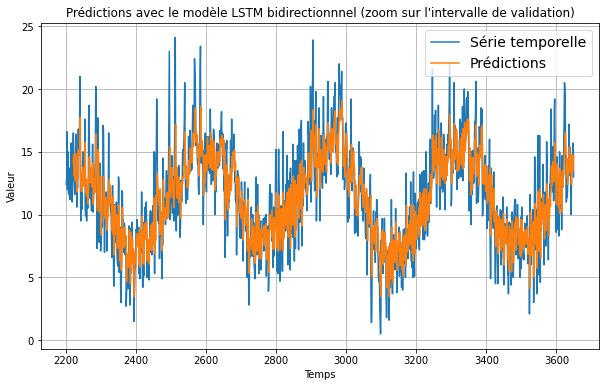

In [ ]:
# Affiche la série et les prédictions
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie,label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0],label="Prédictions")
plt.title('Prédictions avec le modèle LSTM bidirectionnnel')
plt.show()

# Zoom sur l'intervalle de validation
plt.figure(figsize=(10, 6))
affiche_serie(temps[temps_separation:],serie[temps_separation:],label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0],label="Prédictions")
plt.title("Prédictions avec le modèle LSTM bidirectionnnel (zoom sur l'intervalle de validation)")
plt.show()

In [ ]:
# Calcule de l'erreur quadratique moyenne et de l'erreur absolue moyenne 

mae = tf.keras.metrics.mean_absolute_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0]).numpy()
mse = tf.keras.metrics.mean_squared_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0]).numpy()

print(mae)
print(mse)

1.8030996831356954
5.365732406941697


## Choix du modèle :

| **modèle LSTM choisi**                              	| **metrique mse et mae**         	|                         **Observations**                        	| **Caractéristiques du modèle**                                                                                                                   	|   	|
|-----------------------------------------------------	|---------------------------------	|:---------------------------------------------------------------:	|--------------------------------------------------------------------------------------------------------------------------------------------------	|---	|
| **Le modèle de base**                               	| ###########################     	|                     #######################                     	| - une couche récurrente à 40 neurones<br>- une couche dense avec 40 neurones (activation tanh)<br>- une couche dense avec 1 neurone (générateur) 	|   	|
| **LSTM avec sélection <br>du taux d'apprentissage** 	| unitile à cause de l'overfiting 	|                  Le modèle fait de l'overfiting                 	|                                                                                                                                                  	|   	|
| **LSTM avec adaptation<br>du taux d'apprentissage** 	| - mse = 1.808<br>- mae = 5.35   	| on fait décroissance continue <br>du taux d'apprentissage de 1% 	|                                                                                                                                                  	|   	|
| **LSTM avec ajout de la<br>régularisation**         	| - mse = 1.801<br>- mae = 5.322  	|     Le modèle a des performances<br>similaires au précédent     	|                                                                                                                                                  	|   	|
| **LSTM Bi-directionnel**                            	| - mse = 1.803<br>- mae = 5.365  	| Le modèle a des performances <br>similaires au précédent        	|                                                                                                                                                  	|   	|

### CONCLUSION : **Le modèle retenue est le LSTM Bi-Directionnel** 

# 7. Evaluation du modèle retenu sur les années avec le mse

**On crée une boucle qui va nous permettre d'obtenir tout les résultats**

In [ ]:
MyList = []
for i in range(1,10):
  valeur = 30 * 3 * i
  MyList.append(valeur)

for k in MyList:
  temps_separation = 2201
  temps_1987_3Mois = temps_separation + k + 1

  # Extraction des temps et des données d'entrainement
  temps_entrainement = temps[:temps_separation]
  x_entrainement = serie[:temps_separation]

  # Exctraction des temps et des données de validation
  temps_test = temps[temps_separation:temps_1987_3Mois]
  x_test = serie[temps_separation:]

  # Chargement des poids sauvegardés
  model.load_weights("poids.hdf5")

  # Compile le modèle
  model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur,metrics="mae")

  # Entraine le modèle
  historique = model.fit(dataset_norm,validation_data=dataset_Val_norm, epochs=500,verbose=1, callbacks=[CheckPoint,cb])

  taille_fenetre = 20

  # Création d'une liste vide pour recevoir les prédictions
  predictions = []
  Serie_Normalisee = np.array(Serie_Normalisee)

  # Calcul des prédiction pour chaque groupe de 20 valeurs consécutives de la série
  # dans l'intervalle de validation
  for t in temps[temps_separation:-taille_fenetre]:
      X = np.reshape(Serie_Normalisee[t:t+taille_fenetre],(1,taille_fenetre))
      predictions.append(model.predict(X))

  mse = tf.keras.metrics.mean_squared_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions*std+mean)[:,0,0]).numpy()
  print("La valeur du mse obtenue ", round(k/(3*30)), " trimestres plus tard est ", round(mse, 3))


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
68/68 [==============================] - 2s 28ms/step - loss: 0.1754 - mae: 0.4742 - val_loss: 0.1580 - val_mae: 0.4451
Epoch 252/500
67/68 [============================>.] - ETA: 0s - loss: 0.1755 - mae: 0.4742
Epoch 252: loss did not improve from 0.17107
68/68 [==============================] - 2s 28ms/step - loss: 0.1756 - mae: 0.4745 - val_loss: 0.1587 - val_mae: 0.4461
Epoch 253/500
68/68 [==============================] - ETA: 0s - loss: 0.1759 - mae: 0.4748
Epoch 253: loss did not improve from 0.17107
68/68 [==============================] - 2s 29ms/step - loss: 0.1759 - mae: 0.4748 - val_loss: 0.1581 - val_mae: 0.4459
Epoch 254/500
68/68 [==============================] - ETA: 0s - loss: 0.1760 - mae: 0.4751
Epoch 254: loss did not improve from 0.17107
68/68 [==============================] - 2s 29ms/step - loss: 0.1760 - mae: 0.4751 - val_loss: 0.1589 - val_mae: 0.4467
Epoch 255/500
65/68 [==========

# CONCLUSION FINALE DE L'ETUDE : LES RESULTATS

|   **Evaluation year** 	| **Next 3 months** 	| **Next 6 months** 	| **Next 12 months** 	|
|:---------------------:	|:-----------------:	|:-----------------:	|:------------------:	|
|        **1987**       	|       mse = 5.369 	|    mse = 5.371    	|     mse = 5.376    	|
|        **1988**       	|       mse = 5.379 	|    mse = 5.387    	|        mse = 5.398 	|
|        **1989**       	|       mse = 5.398 	|     mse = 5.399   	|         mse = 5.4  	|